In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from pathlib import Path


In [2]:
data_dir = './input/'
# data_dir = Path("../input/house-prices-advanced-regression-techniques/")
X_train = pd.read_csv(data_dir + 'train.csv', index_col="id")
X_test = pd.read_csv(data_dir + 'test.csv', index_col="id")

## EDA (Exploratory Data Analysis)

hasil :
### missing values :
Missing values:
- Guest_Popularity_percentage    (146030) (19%)
- Episode_Length_minutes          (87093) (12%)
- Number_of_Ads                       (1)

In [3]:
def explore_data(df):
    print(f"DataFrame shape: {df.shape}")
    print(f"DataFrame columns: {df.columns.tolist()}")
    print(f"DataFrame info:\n{df.info()}")
    print(f"DataFrame description:\n{df.describe(include='all')}")
    print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False).head(20)}")
    print(f"Duplicate rows: {df.duplicated().sum()}")

In [4]:
explore_data(X_train)

DataFrame shape: (750000, 11)
DataFrame columns: ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Listening_Time_minutes']
<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads    

In [5]:
X_train

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000


## Preprocessing

beberapa funtion untuk preprocessing :

- clean() - potensi regex
- encode() 
- impute() - masih bisa dikembangin


In [6]:
# disini bisa buat fitur episode_number
def clean(df):

    df['Episode_Number'] = df['Episode_Title'].str.extract(r'(\d+)').astype(float)
    df = df.drop('Episode_Title', axis=1)

    return df

    

In [7]:
def encode(df):
    # The nominative (unordered) categorical features
    features_nom = [
    'Podcast_Name',
    'Genre',
    'Publication_Day',
    ]
    
    features_ord = ['Episode_Sentiment', 'Publication_Time']

    ordered_levels = {
        'Episode_Sentiment': ['Negative', 'Neutral', 'Positive'],
        'Publication_Time': ['Morning', 'Afternoon', 'Evening', 'Night']
    }

    # Add a None level for missing values
    ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

    
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    
    return df
    

In [8]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df


## Load Data

- load_data()
- panggil load_data()

In [9]:
def load_data():
    #Read data
    data_dir = 'input/'
    # data_dir = Path("../input/house-prices-advanced-regression-techniques/")

    df_train = pd.read_csv(data_dir + 'train.csv', index_col="id")
    df_test = pd.read_csv(data_dir + 'test.csv', index_col="id")

    #Merge the splits so we can preprocess them together
    df = pd.concat([df_train, df_test])
    #Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    #reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]


    return df_train, df_test

## Base line

- score_dataset()
- cek liat score

Baseline : 13.20727 RMSE

In [10]:
df_train, df_test = load_data()

In [11]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes("category"):
        X[colname] = X[colname].cat.codes
    
    # Cross-validation pakai RMSE
    score = cross_val_score(
        model, X, y, 
        cv=10,
        scoring="neg_mean_squared_error"
    )

    score = -1 * score.mean()
    score = np.sqrt(score)  #matriknya make rmse
    return score


X = df_train.copy()
y = X.pop("Listening_Time_minutes")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSE")


Baseline score: 13.19883 RMSE


## Feature Engineering

- cluster_labels : naik dari 13.20727 jadi 13.195928278925823
- pca_components : turun dari 13.20727 jadi 13.226382669875116

In [12]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [13]:
X = df_train.copy()
y = X.pop("Listening_Time_minutes")

mi_scores = make_mi_scores(X, y)
print("Mutual Information Scores:")
mi_scores

Mutual Information Scores:


Episode_Length_minutes         2.036795
Host_Popularity_percentage     0.762879
Episode_Number                 0.684967
Guest_Popularity_percentage    0.642437
Podcast_Name                   0.416703
Publication_Day                0.243486
Number_of_Ads                  0.238516
Genre                          0.199015
Publication_Time               0.175717
Episode_Sentiment              0.141619
Name: MI Scores, dtype: float64

In [14]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [15]:
#create features with pandas

def mathematical_transforms(df):
    pass


### K-means clustering


In [16]:
#K-means clustering

cluster_features = [
    "Episode_Length_minutes",
    "Host_Popularity_percentage",
    "Guest_Popularity_percentage",
    "Episode_Number"
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)               #TUNING
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)                          #TUNING
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [24]:
df_cluster_labels= cluster_labels(X, cluster_features, n_clusters=20)
df_cluster_distance = cluster_distance(X, cluster_features, n_clusters=20)


In [25]:
df_cluster = pd.concat([df_cluster_labels, df_cluster_distance], axis=1)
df_cluster

,Cluster,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,...,Centroid_10,Centroid_11,Centroid_12,Centroid_13,Centroid_14,Centroid_15,Centroid_16,Centroid_17,Centroid_18,Centroid_19
0,4,3.010509,3.801805,2.675283,4.198374,1.095845,3.475447,3.436084,2.818004,2.390641,...,3.650241,3.181609,3.899121,2.588240,4.455128,2.650650,2.929395,3.503088,3.981208,2.997944
1,3,2.529697,2.341916,3.070589,1.042411,3.728678,1.442270,2.617002,2.414838,3.271104,...,2.180995,3.579887,2.778544,2.833784,1.505014,3.435151,3.457286,2.055932,2.438948,3.005558
2,0,0.725581,3.274965,2.488198,2.091364,2.551230,1.934345,2.354384,2.813671,3.225522,...,0.863819,2.054970,2.699921,2.240856,2.444670,1.634921,3.585258,3.041642,1.593313,2.559241
3,7,2.082159,1.565732,1.680886,1.399368,2.774114,1.315598,1.687282,1.072365,2.017074,...,2.526541,2.689302,1.572775,2.623289,1.243629,2.749193,1.898600,1.770163,2.390555,2.496301
4,17,2.957881,2.058777,3.114015,2.317026,2.747770,1.523643,3.174929,1.811516,2.465993,...,2.629491,4.059833,3.688819,1.573364,2.916852,3.590782,3.041665,0.745708,3.235470,2.385243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,0,0.736149,3.239798,2.492015,2.329851,2.346262,1.904994,2.584864,2.812198,3.227213,...,0.872966,2.077963,2.908934,1.963311,2.624907,1.684936,3.570354,3.019756,1.568173,2.306133
749996,18,1.369815,2.994310,2.259039,3.029721,3.098090,2.235229,3.217213,3.143920,3.869008,...,2.207560,1.534696,2.615924,2.852226,2.254656,2.585217,3.385310,3.707668,0.625952,2.021478
749997,6,2.513306,2.625111,2.019938,1.843862,2.418177,2.291827,1.029959,1.219751,1.032841,...,2.924369,3.068736,2.014941,2.890066,2.548381,2.438910,2.067192,1.965703,3.417059,3.327369
749998,14,2.950753,1.332297,2.688974,1.925889,3.830063,1.580241,2.912088,2.012460,3.132711,...,3.100579,3.582609,2.476409,3.152024,1.166306,3.910079,2.662740,2.091837,2.616036,2.725935


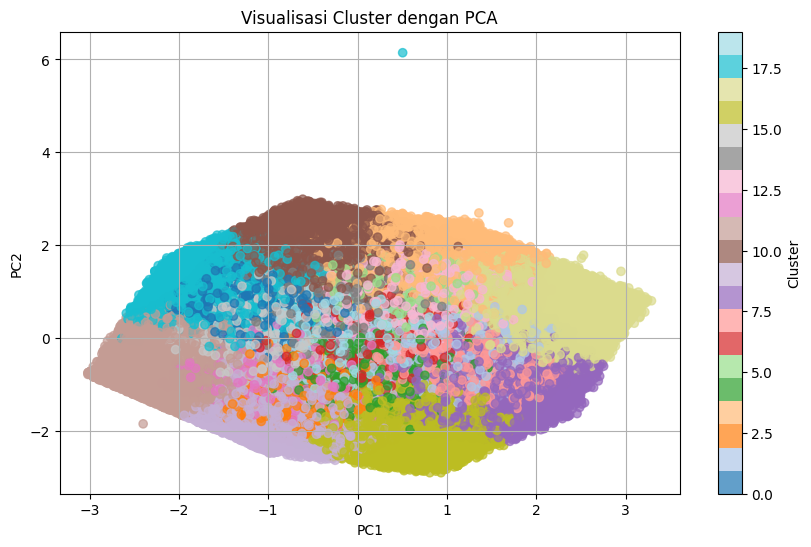

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling ulang agar cocok untuk PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[cluster_features])

# PCA untuk reduksi ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Gabungkan hasil PCA dan label cluster
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_cluster['Cluster']

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='tab20', alpha=0.7)
plt.title('Visualisasi Cluster dengan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

### PCA (Principal Component Analysis)

- pca_components()

In [33]:
#Principal Component Analysis

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


#gabung-gabungin feature dari analysis PCA
def pca_inspired(df):
    pass

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

pca_features = [
    "Episode_Length_minutes",         # MI tinggi
    "Host_Popularity_percentage",
    "Guest_Popularity_percentage",
    "Episode_Number",
    "Number_of_Ads"
]


In [37]:
X_pca = pca_components(X, pca_features)
X_pca

,PC1,PC2,PC3,PC4,PC5
0,0.119857,1.103150,1.108162,-1.692417,-1.790341
1,-0.959265,-0.789147,-0.228006,1.402177,1.256861
2,-0.326783,-1.845508,0.545230,-0.718242,-0.235128
3,-0.253083,0.311175,-0.570820,0.551576,0.955160
4,-0.765062,1.025744,0.869273,2.053519,0.243862
...,...,...,...,...,...
749995,-0.278269,-1.735690,0.688885,-0.625619,-0.604618
749996,1.318441,-1.474102,-0.236746,0.685685,-0.332938
749997,-1.240113,0.535334,-0.204157,-1.369580,0.698668
749998,-1.826873,-0.497569,-1.554102,0.379491,0.167730


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

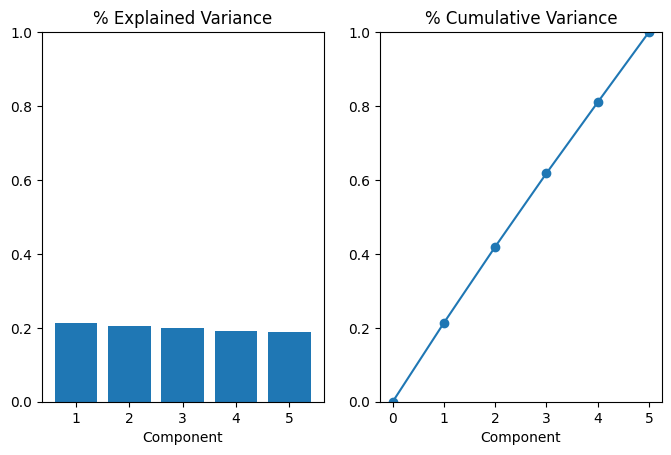

In [41]:
df_pca = X.loc[:, pca_features]
pca, X_pca, loadings = apply_pca(df_pca)
plot = plot_variance(pca)
plot

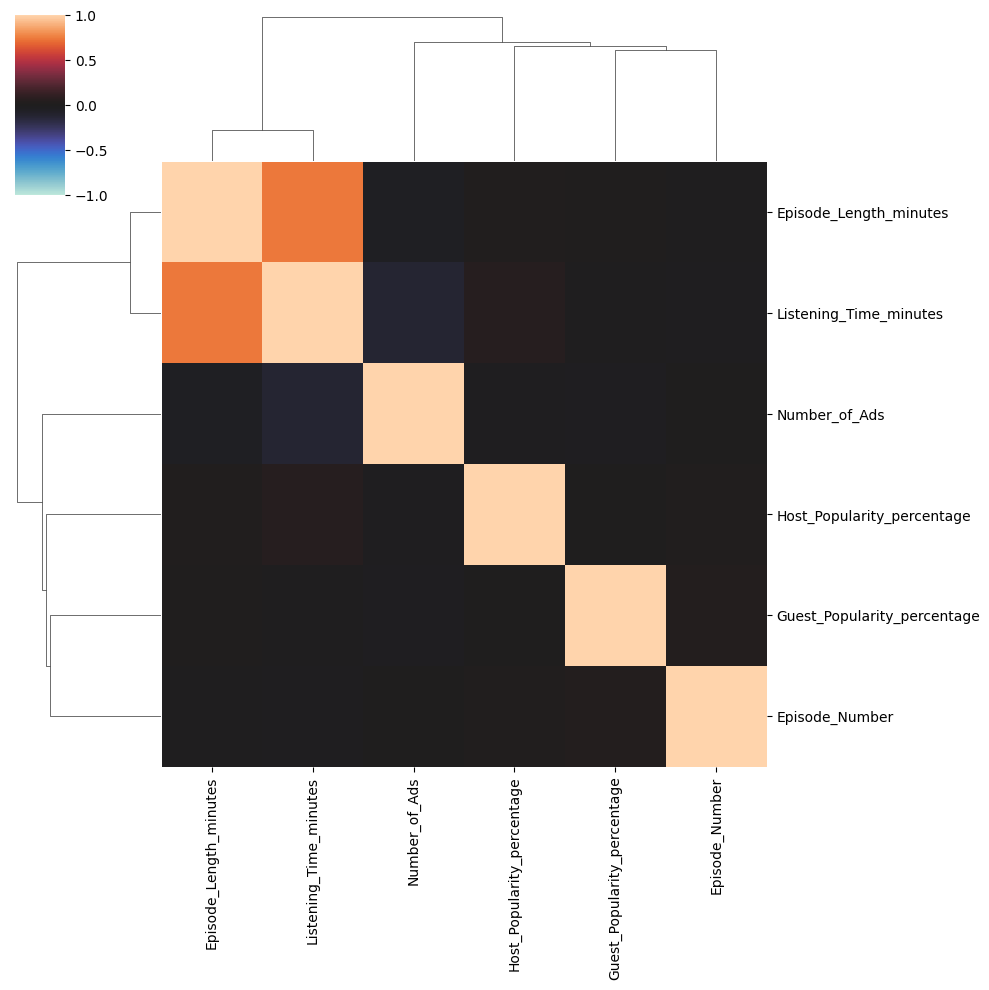

In [25]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

## Train & Predict

In [ ]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("Listening_Time_minutes")

    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("Listening_Time_minutes")
        X = pd.concat([X, X_test])


    X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(pca_components(X, pca_features))

    X = label_encode(X)
    
    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    
    if df_test is not None:
        return X, X_test
    else:
        return X


### Evaluasi hasil create features

In [49]:
df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:,'Listening_Time_minutes']

score_dataset(X_train, y_train)

np.float64(13.225586531212237)

In [ ]:
X_train

### Train model

In [ ]:
xgb = XGBRegressor()

xgb.fit(X_train, y)
y_pred = xgb.predict(X_test)


## Submission


In [29]:
def make_submisson():
    output = pd.DataFrame({'id': X_test.index, 'Listening_Time_minutes': y_pred})
    output.to_csv('my_submission2.csv', index=False)
    print("Your submission was successfully saved!")

In [30]:
make_submisson()

Your submission was successfully saved!
